### ResNet Ablation
---
#### 실습목표
---
1. 직접 ResNet 구현하기
2. 모델을 config에 따라서 변경가능하도록 만들기
3. 직접 실험해서 성능 비교하기

#### 학습내용
- Ablation Study
- Back to the 2015
- Block
- Complete Model
- Experiment

### Ablation Study
 - CIFAR-10에 대해 일반 네트워크와 ResNet을 구현해서 이 둘을 비교하여 ResNet 및 residual connection의 유효성을 확인

   
#### (1) CIFAR-10 데이터셋 준비
- [CIFAR-10 데이터셋](https://www.tensorflow.org/datasets/catalog/cifar10)
- pip install tensorflow-datasets

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type="GPU")
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 6GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    except RuntimeError as e:
        print(e)

In [5]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [6]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [7]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


#### Input Normalization

In [8]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [9]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_info.features["label"].num_classes

10

In [11]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

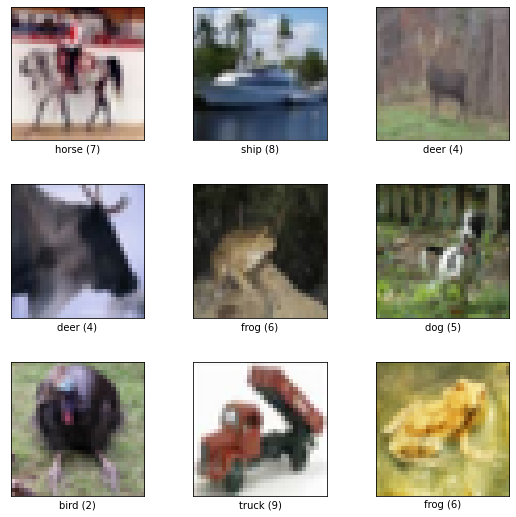

In [12]:
fig = tfds.show_examples(ds_train, ds_info)

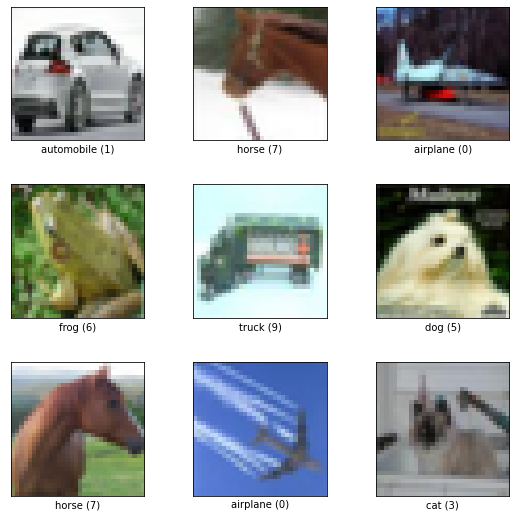

In [13]:
fig = tfds.show_examples(ds_test, ds_info)

#### (2) 블록 구성
      
#### VGG의 블록의 특징   
  - CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어짐
  - CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있음
  - 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있음
  - 블록에 따라서 CNN 레이어의 갯수 또한 달라짐
  - 블록의 마지막에는 항상 Max Pooling 레이어가 붙음
  

In [14]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [15]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [16]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


#### (3) VGG Complete Model

1) VGG-16

In [17]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [18]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

2) VGG-19

In [19]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

#### (4) VGG-16 vs VGG-19

In [20]:
BATCH_SIZE = 256
EPOCH = 20

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [22]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 51s 171ms/step - loss: 2.2322 - accuracy: 0.1604 - val_loss: 2.0360 - val_accuracy: 0.2600
Epoch 2/20
195/195 [==============================] - 16s 81ms/step - loss: 2.0311 - accuracy: 0.2628 - val_loss: 1.9369 - val_accuracy: 0.3112
Epoch 3/20
195/195 [==============================] - 16s 81ms/step - loss: 1.8920 - accuracy: 0.3181 - val_loss: 1.7887 - val_accuracy: 0.3713
Epoch 4/20
195/195 [==============================] - 16s 82ms/step - loss: 1.7807 - accuracy: 0.3613 - val_loss: 1.7170 - val_accuracy: 0.4071
Epoch 5/20
195/195 [==============================] - 16s 81ms/step - loss: 1.6914 - accuracy: 0.3931 - val_loss: 1.6259 - val_accuracy: 0.4269
Epoch 6/20
195/195 [==============================] - 16s 82ms/step - loss: 1.6222 - accuracy: 0.4138 - val_loss: 1.5763 - val_accuracy: 0.4412
Epoch 7/20
195/195 [==============================] - 16s 82ms/step - loss: 1.5660 - accuracy: 0.4340 - val_loss: 1.5385 - val_accuracy

In [23]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 22s 100ms/step - loss: 2.2820 - accuracy: 0.1428 - val_loss: 2.1490 - val_accuracy: 0.1756
Epoch 2/20
195/195 [==============================] - 19s 97ms/step - loss: 2.1198 - accuracy: 0.2158 - val_loss: 2.0204 - val_accuracy: 0.2848
Epoch 3/20
195/195 [==============================] - 19s 96ms/step - loss: 1.9766 - accuracy: 0.2751 - val_loss: 1.8785 - val_accuracy: 0.3299
Epoch 4/20
195/195 [==============================] - 19s 97ms/step - loss: 1.8542 - accuracy: 0.3271 - val_loss: 1.7779 - val_accuracy: 0.3544
Epoch 5/20
195/195 [==============================] - 19s 97ms/step - loss: 1.7594 - accuracy: 0.3608 - val_loss: 1.6895 - val_accuracy: 0.3838
Epoch 6/20
195/195 [==============================] - 19s 97ms/step - loss: 1.6751 - accuracy: 0.3943 - val_loss: 1.6429 - val_accuracy: 0.4135
Epoch 7/20
195/195 [==============================] - 19s 97ms/step - loss: 1.6138 - accuracy: 0.4185 - val_loss: 1.6622 - val_accuracy

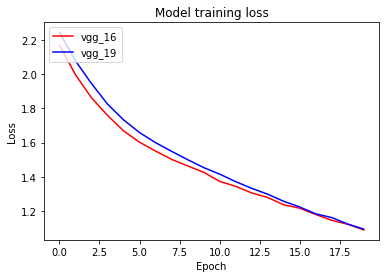

In [24]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

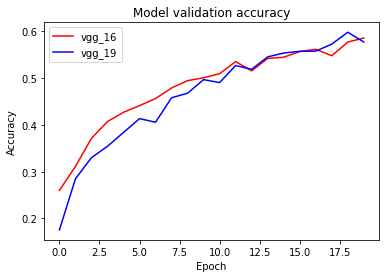

In [25]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

#### 프로젝트: ResNet Ablation Study
1) ResNet 기본 블록 구성
- [Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)

In [5]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def build_res_net():
    
    inputs = Input(shape=(32, 32, 3))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(10, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [6]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def build_plain_net():
    
    inputs = Input(shape=(32, 32, 3))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [4, 10, 10, 4]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            downsample = (j==0 and i!=0)
            t = Conv2D(kernel_size=3,
                       strides= (1 if not downsample else 2),
                       filters=num_filters,
                       padding="same")(t)
            t = relu_bn(t)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(10, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [19]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

model = create_res_net() # or create_plain_net()
model.summary()

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'cifar-10_res_net_30-'+timestr # or 'cifar-10_plain_net_30-'+timestr

checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

# save model after each epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1
)
tensorboard_callback = TensorBoard(
    log_dir='tensorboard_logs/'+name,
    histogram_freq=1
)

results= model.fit(
    x=x_train,
    y=y_train,
    epochs=20,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=128,
    callbacks=[cp_callback, tensorboard_callback]
)



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 32, 32, 3)    12          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 32, 32, 64)   1792        batch_normalization_60[0][0]     
__________________________________________________________________________________________________
re_lu_58 (ReLU)                 (None, 32, 32, 64)   0           conv2d_64[0][0]                  
____________________________________________________________________________________________

Epoch 1/20
391/391 [==============================] - 49s 119ms/step - loss: 1.7605 - accuracy: 0.3768 - val_loss: 1.3197 - val_accuracy: 0.5579

Epoch 00001: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0001.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0001.ckpt/assets


Epoch 2/20
391/391 [==============================] - 46s 116ms/step - loss: 1.0752 - accuracy: 0.6209 - val_loss: 1.3153 - val_accuracy: 0.6406

Epoch 00002: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0002.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0002.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0002.ckpt/assets


Epoch 3/20
391/391 [==============================] - 46s 117ms/step - loss: 0.8309 - accuracy: 0.7123 - val_loss: 1.1253 - val_accuracy: 0.6671

Epoch 00003: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0003.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0003.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0003.ckpt/assets


Epoch 4/20
391/391 [==============================] - 46s 117ms/step - loss: 0.6589 - accuracy: 0.7770 - val_loss: 0.7272 - val_accuracy: 0.7589

Epoch 00004: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0004.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0004.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0004.ckpt/assets


Epoch 5/20
391/391 [==============================] - 46s 117ms/step - loss: 0.5361 - accuracy: 0.8202 - val_loss: 0.7160 - val_accuracy: 0.7707

Epoch 00005: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0005.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0005.ckpt/assets


Epoch 6/20
391/391 [==============================] - 46s 117ms/step - loss: 0.4512 - accuracy: 0.8448 - val_loss: 1.3012 - val_accuracy: 0.7223

Epoch 00006: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0006.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0006.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0006.ckpt/assets


Epoch 7/20
391/391 [==============================] - 46s 117ms/step - loss: 0.4071 - accuracy: 0.8610 - val_loss: 0.6485 - val_accuracy: 0.7897

Epoch 00007: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0007.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0007.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0007.ckpt/assets


Epoch 8/20
391/391 [==============================] - 46s 117ms/step - loss: 0.3338 - accuracy: 0.8858 - val_loss: 0.6683 - val_accuracy: 0.7981

Epoch 00008: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0008.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0008.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0008.ckpt/assets


Epoch 9/20
391/391 [==============================] - 46s 117ms/step - loss: 0.2719 - accuracy: 0.9071 - val_loss: 0.5356 - val_accuracy: 0.8290

Epoch 00009: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0009.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0009.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0009.ckpt/assets


Epoch 10/20
391/391 [==============================] - 46s 117ms/step - loss: 0.2238 - accuracy: 0.9230 - val_loss: 0.5569 - val_accuracy: 0.8286

Epoch 00010: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0010.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0010.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0010.ckpt/assets


Epoch 11/20
391/391 [==============================] - 46s 117ms/step - loss: 0.1937 - accuracy: 0.9343 - val_loss: 0.5563 - val_accuracy: 0.8356

Epoch 00011: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0011.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0011.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0011.ckpt/assets


Epoch 12/20
391/391 [==============================] - 46s 117ms/step - loss: 0.1626 - accuracy: 0.9446 - val_loss: 0.4939 - val_accuracy: 0.8521

Epoch 00012: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0012.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0012.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0012.ckpt/assets


Epoch 13/20
391/391 [==============================] - 46s 117ms/step - loss: 0.1253 - accuracy: 0.9579 - val_loss: 0.6192 - val_accuracy: 0.8285

Epoch 00013: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0013.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0013.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0013.ckpt/assets


Epoch 14/20
391/391 [==============================] - 46s 117ms/step - loss: 0.1172 - accuracy: 0.9595 - val_loss: 0.6164 - val_accuracy: 0.8326

Epoch 00014: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0014.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0014.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0014.ckpt/assets


Epoch 15/20
391/391 [==============================] - 46s 118ms/step - loss: 0.1207 - accuracy: 0.9577 - val_loss: 0.6122 - val_accuracy: 0.8391

Epoch 00015: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0015.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0015.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0015.ckpt/assets


Epoch 16/20
391/391 [==============================] - 46s 118ms/step - loss: 0.0789 - accuracy: 0.9740 - val_loss: 0.6307 - val_accuracy: 0.8389

Epoch 00016: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0016.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0016.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0016.ckpt/assets


Epoch 17/20
391/391 [==============================] - 46s 117ms/step - loss: 0.0717 - accuracy: 0.9759 - val_loss: 0.6599 - val_accuracy: 0.8376

Epoch 00017: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0017.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0017.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0017.ckpt/assets


Epoch 18/20
391/391 [==============================] - 46s 117ms/step - loss: 0.0709 - accuracy: 0.9759 - val_loss: 0.6220 - val_accuracy: 0.8498

Epoch 00018: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0018.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0018.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0018.ckpt/assets


Epoch 19/20
391/391 [==============================] - 46s 118ms/step - loss: 0.0617 - accuracy: 0.9796 - val_loss: 0.6610 - val_accuracy: 0.8419

Epoch 00019: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0019.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0019.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0019.ckpt/assets


Epoch 20/20
391/391 [==============================] - 46s 118ms/step - loss: 0.0638 - accuracy: 0.9785 - val_loss: 0.6884 - val_accuracy: 0.8410

Epoch 00020: saving model to checkpoints/cifar-10_res_net_30-20210408-003831/cp-0020.ckpt
INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0020.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/cifar-10_res_net_30-20210408-003831/cp-0020.ckpt/assets


KeyError: 'acc'

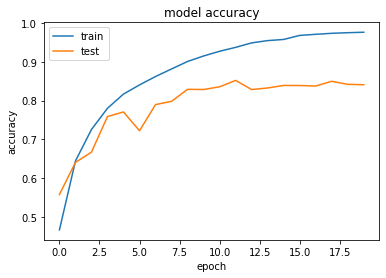

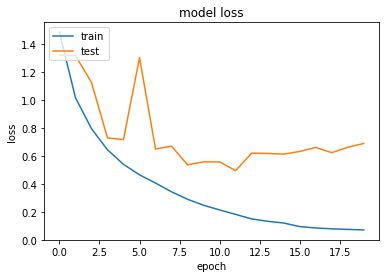

In [23]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()